# 화해 사전TEST 과제     
가입후 7일 이내 재방문율 증가를 위한 인사이트 탐색

## 데이터 탐색 전 호기심과 가설

- 화해에 가입한 이유는 무엇일까요?     
- 화해 사용자의 7일 이내 재방문율은 얼마일까요?
- 화해 고객들의 user_path은 얼마일까요?
- 7일 이내 재방문 고객의 화해 Session time은 어느정도일까요?      

- 양방향 커뮤니케이션을 지향하는 화해에서는 고객의 Session Time이 길어질수록 브랜드 충성도가 높아질 것입니다.
- 7일 이내 재방문 고객의 전체 충성도가 높을 것입니다.

## EDA

**용어 정의**    
- 가입후 7일 이내 재방문율  = 가입자 중에서 (가입일+1)일 부터 (가입일+7)일 이내에 재방문하는 사용자의 비율 

**columns**    
- user_id: 사용자id(식별자)    
- event: 사용자의 앱 내 행동     
- time: event가 발생한 시간 ( KST, 한국시 기준 ) 

In [68]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [69]:
all_data = pd.read_csv("./dataset/log.csv", encoding = 'utf-8')
all_data.head()

,user_id,event,time
0,0,register,2018-08-24 19:34:36
1,0,view_product_search,2018-08-24 19:34:48
2,0,view_ingredient,2018-08-24 19:34:52
3,0,view_ingredient,2018-08-24 19:34:55
4,0,view_ingredient,2018-08-24 19:34:58


In [70]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091527 entries, 0 to 1091526
Data columns (total 3 columns):
user_id    1091527 non-null int64
event      1091527 non-null object
time       1091527 non-null object
dtypes: int64(1), object(2)
memory usage: 25.0+ MB


In [71]:
all_data['event'].value_counts()

view_ingredient         433635
view_review             429567
view_product_ranking     71158
view_product_search      70455
view_event               38203
view_hwahaeplus          37218
login                     6291
register                  5000
Name: event, dtype: int64

view_ingredient : 특정 성분 클릭     
view_review : 특정 리뷰 클릭    
view_product_ranking : 랭킹 제품 클릭    
view_product_search : 검색 제품 클릭    
view_event : 이벤트 클릭    
view_hwahaeplus : 화플 클릭    
login : 가입 후 재방문    
register : 가입(최초 방문)    

## Event별 상관관계 분석
R스크립트로 진행했습니다.

## dummy 행렬 만들기

In [72]:
# data를 넣기 쉽게 하기 위해서 
dummy = np.zeros(shape=(5000, 8), dtype=np.float32)
columns = ['register', 'login', 'view_product_search', 'view_product_ranking', 
           'view_ingredient', 'view_review', 'view_hwahaeplus', 'view_event']

In [73]:
time1 = all_data['time'][316]
time2 = all_data['time'][317]
data1 = datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
data2 = datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')

sub = data2 - data1
sub.total_seconds()

314499.0

In [74]:
all_data['time_cost'] = 0
all_data_np = np.array(all_data) # 연산 속도 위해서 
print(all_data_np)

[[0 'register' '2018-08-24 19:34:36' 0]
 [0 'view_product_search' '2018-08-24 19:34:48' 0]
 [0 'view_ingredient' '2018-08-24 19:34:52' 0]
 ...
 [4999 'view_ingredient' '2018-08-20 03:11:18' 0]
 [4999 'view_ingredient' '2018-08-20 03:11:23' 0]
 [4999 'view_review' '2018-08-20 03:11:24' 0]]


## User_path : 메뉴별 체류시간

In [75]:
for i in range(len(all_data_np) - 1):
    # 각 이벤트마다 시간 차이 구하기 #
    if all_data_np[i, 0] == all_data_np[i+1, 0]:
        time1 = all_data_np[i, 2]
        time2 = all_data_np[i+1, 2]
        data1 = datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
        data2 = datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')
        sub = data2 - data1
        all_data_np[i, -1] = sub.total_seconds()

In [77]:
for i in range(len(all_data_np) - 1):
    if all_data_np[i+1, 1] != 'login':
        dummy[all_data_np[i, 0], columns.index(all_data_np[i, 1])] += all_data_np[i, 3]

In [78]:
time_df = pd.DataFrame(dummy)
time_df.columns = columns
time_df.head()

,register,login,view_product_search,view_product_ranking,view_ingredient,view_review,view_hwahaeplus,view_event
0,12.0,0.0,24.0,0.0,57.0,73.0,33.0,0.0
1,6.0,55.0,221.0,212.0,2328.0,2505.0,248.0,278.0
2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,34.0,45.0,74.0,369.0,313.0,82.0,195.0
4,14.0,0.0,12.0,0.0,20.0,38.0,15.0,49.0


## register 후에 login이 있다면, login까지 시간(day)

In [85]:
login_time = np.zeros(shape=(5000, 1))
for i in range(len(all_data_np)):
    if all_data_np[i, 1] == 'register':
        time1 = all_data_np[i, 2]
        data1 = datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
    if all_data_np[i, 1] == 'login':
        time2 = all_data_np[i, 2]
        data2 = datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')
        sub = data2 - data1
        if sub.days <= 7:
            login_time[all_data_np[i,0]] = 1

## 7일 이내 재방문율

In [86]:
login_time_df = pd.DataFrame(login_time)
visit_per = len(login_time_df[login_time_df[0]==1]) / len(login_time_df)
print(visit_per)

0.397


## 가입후 재방문이 없는 경우

In [87]:
login_people = np.zeros(shape=(5000, 1))
for i in range(len(all_data_np)):
    if all_data_np[i, 1] == 'register':
        time1 = all_data_np[i, 2]
        data1 = datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
    if all_data_np[i, 1] == 'login':
        time2 = all_data_np[i, 2]
        data2 = datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')
        sub = data2 - data1
        login_people[all_data_np[i,0]] = 1

login_people_df = pd.DataFrame(login_people)        
no_visit = len(login_people_df[login_people_df[0] == 0]) / len(login_people)
print(no_visit)

0.4334


## K-means

In [88]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [89]:
# scaling #
mm = MinMaxScaler()
time_df_scale = mm.fit_transform(time_df)

kmeans = KMeans(n_clusters=5, max_iter=1000, random_state=77)
res = kmeans.fit_predict(time_df_scale)

time_df['res'] = res
time_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,register,login,view_product_search,view_product_ranking,view_ingredient,view_review,view_hwahaeplus,view_event,res
0,12.0,0.0,24.0,0.0,57.0,73.0,33.0,0.0,4
1,6.0,55.0,221.0,212.0,2328.0,2505.0,248.0,278.0,1
2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,10.0,34.0,45.0,74.0,369.0,313.0,82.0,195.0,2
4,14.0,0.0,12.0,0.0,20.0,38.0,15.0,49.0,4


## register 후에 일어나는 event 확률 구하기

In [90]:
prob_after_register = np.zeros(shape=(5000, 8))
for i in range(len(all_data_np)-1):
    if all_data_np[i, 1] == 'register':
        prob_after_register[all_data_np[i,0], columns.index(all_data_np[i+1, 1])] = 1

pa_register_df = pd.DataFrame(prob_after_register)
pa_register_df.columns = columns

## 가입만 하고 재방문 없는 경우

In [92]:
len(pa_register_df[pa_register_df['register'] == 1])##-->0.14%

7

## 빈도 구하기

In [99]:
count_list = []
for col in columns:
    count_list.append(len(pa_register_df[pa_register_df[col] == 1]))

count = np.array(count_list)
prob_count = count / 5000
prob_register = pd.DataFrame(count)
prob_register['prob'] = prob_count
prob_register = prob_register.T
prob_register.columns = columns
prob_register.head()

,register,login,view_product_search,view_product_ranking,view_ingredient,view_review,view_hwahaeplus,view_event
0,7.0000,1.0000,1238.0000,1268.0000,0.0,0.0,1253.0000,1233.0000
prob,0.0014,0.0002,0.2476,0.2536,0.0,0.0,0.2506,0.2466


## login 후에 일어나는 event one-hot

In [98]:
prob_after_login = np.zeros(shape=(5000, 8))
for i in range(len(all_data_np)-1):
    if all_data_np[i, 1] == 'register':
        time1 = all_data_np[i, 2]
        data1 = datetime.strptime(time1, '%Y-%m-%d %H:%M:%S')
    if all_data_np[i, 1] == 'login':
        time2 = all_data_np[i, 2]
        data2 = datetime.strptime(time2, '%Y-%m-%d %H:%M:%S')
        sub = data2 - data1
        if sub.days <= 7:
            prob_after_login[all_data_np[i,0], columns.index(all_data_np[i+1, 1])] = 1

prob_after_login_df = pd.DataFrame(prob_after_login)
prob_after_login_df.columns = columns
count_list = []
for col in columns:
    count_list.append(len(prob_after_login_df[prob_after_login_df[col] == 1]))
count_login = pd.DataFrame(count_list).T
count_login.columns = columns
count_login.head()

,register,login,view_product_search,view_product_ranking,view_ingredient,view_review,view_hwahaeplus,view_event
0,1,1,597,656,0,0,600,654


## PCA : 차원축소

In [47]:
from sklearn.decomposition import pca
import matplotlib.pyplot as plt

In [48]:
pca_r = pca.PCA(n_components=2, random_state=77)
pca_df = pd.DataFrame(pca_r.fit_transform(time_df_scale))
np.sum(pca_r.explained_variance_ratio_)

pca_df['res'] = res.reshape(5000,1)

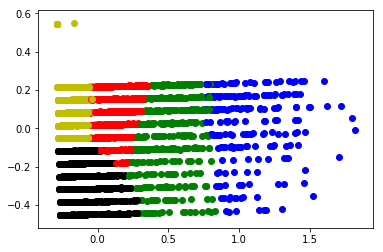

In [49]:
plt.figure()
color_list = ['r', 'b', 'g', 'y', 'k']
for i in range(len(pca_df)):
    plt.scatter(pca_df.iloc[i, 0], pca_df.iloc[i, 1], c=color_list[pca_df.iloc[i,2]])
plt.show()

## 분석결과

- 상관분석에서 7일이내 재방문 고객들은 view_ingredient, view_review 변수와 상관관계가 높았습니다.     
  -> 가입 후 재방문 고객들은 특정 성분과 리뷰에 관심이 많았습니다.
- PCA 차원축소 후 군집화를 보면, Session time이 길수록 heavy user로 파악됩니다.   
- 첫 방문 고객의 경우 화해의 모든 페이지에 방문하므로 각 서비스의 단계별 사용 경험에 따른 보상이 주어진다면, 
  구매로 이어질 충성고객의 비율이 높아질 것입니다. (화해를 알아가는 고객에게 애정을 실어주는 방법)

## 한계점

- 데이터의 변수가 빈도를 기반으로 하므로 Kmeans를 사용하는 것은 한계가 있었습니다.
- 수정한다면, K-modes 알고리즘을 사용한다면 더 좋은 결과가 나올 것으로 예상합니다.